In [1]:
# Step 1: Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import numpy as np

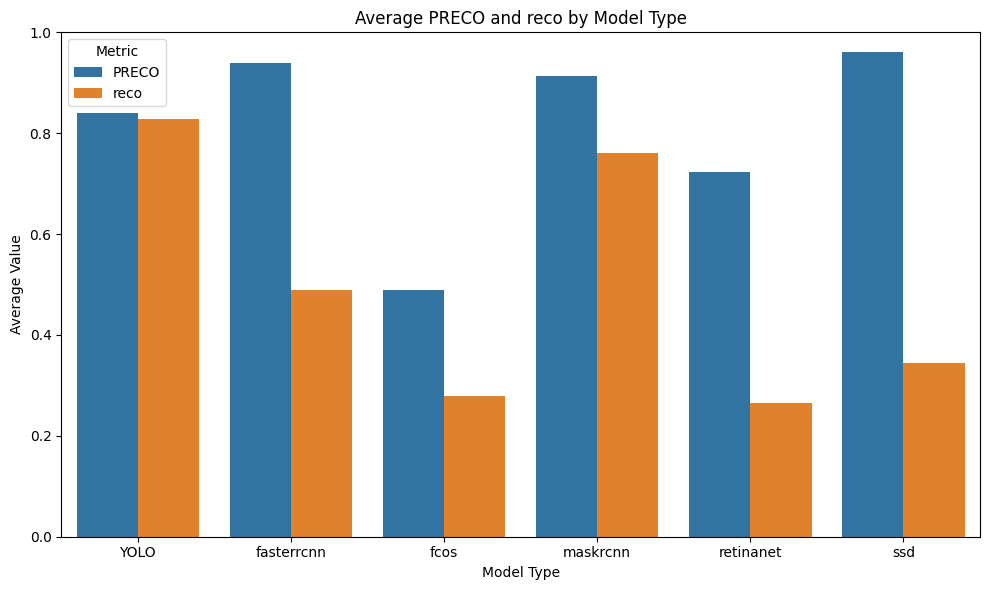

In [10]:
fileName = "./noisy.csv"

df = pd.read_csv(fileName)

# Step 4: Group by modelType and compute mean of PRECO and reco
avg_metrics = df.groupby('modelType')[['PRECO', 'reco']].mean().reset_index()

# Step 5: Melt the DataFrame for plotting
df_melted = avg_metrics.melt(id_vars='modelType', value_vars=['PRECO', 'reco'],
                             var_name='Metric', value_name='Average Value')

# Step 6: Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='modelType', y='Average Value', hue='Metric', data=df_melted)
plt.title('Average PRECO and reco by Model Type')
plt.ylabel('Average Value')
plt.xlabel('Model Type')
plt.ylim(0, 1)  # since both metrics are between 0 and 1
plt.legend(title='Metric')
plt.tight_layout()
plt.savefig("bestPerModel.png", dpi=300, bbox_inches='tight')
plt.show()


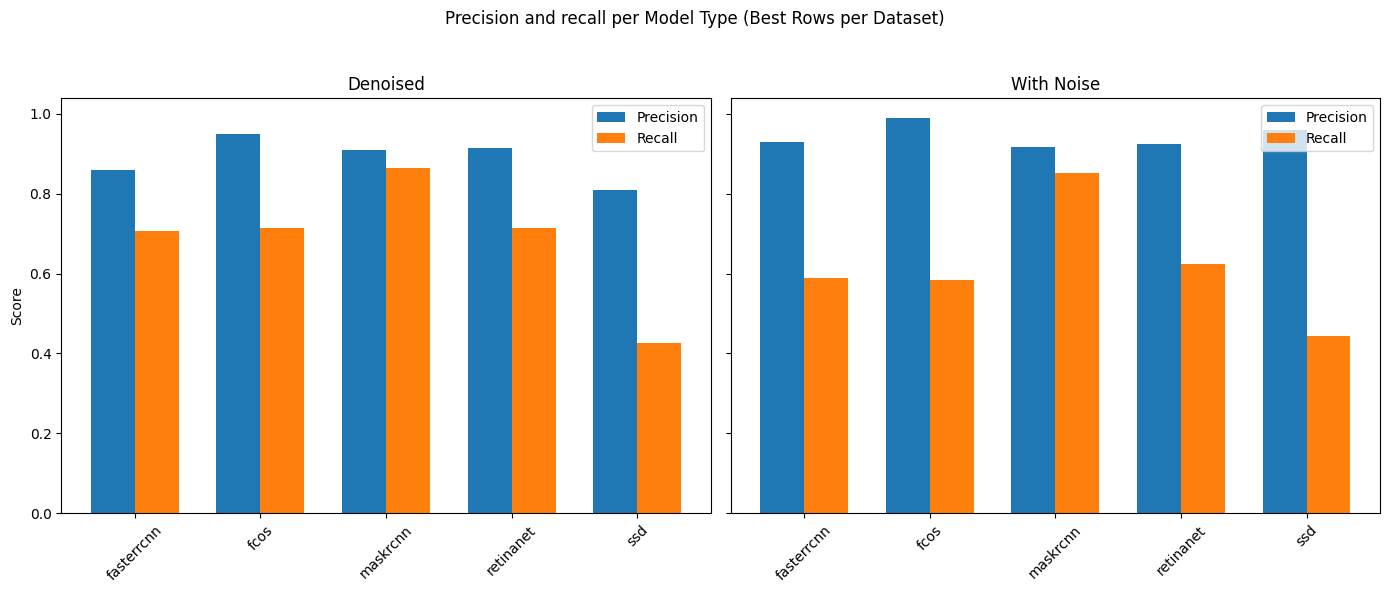

In [12]:
# compare results from two datasets (denoised and not with noise)
# Load datasets
df1 = pd.read_csv("outExpDLFRCNNDenoised.txt")
df2 = pd.read_csv("outExpDLFRCNNWithNoise.txt")

# Get best rows
def get_best(df):
    df['avg'] = df[['PRECO', 'reco']].mean(axis=1)
    best = df.loc[df.groupby('modelType')['avg'].idxmax()]
    return best[['modelType', 'PRECO', 'reco']].set_index('modelType')

best1 = get_best(df1)
best2 = get_best(df2)

# Bar settings
models = best1.index
x = np.arange(len(models))
bar_width = 0.35

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Dataset 1
axes[0].bar(x - bar_width/2, best1['PRECO'], width=bar_width, label='Precision')
axes[0].bar(x + bar_width/2, best1['reco'], width=bar_width, label='Recall')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=45)
axes[0].set_title("Denoised")
axes[0].set_ylabel("Score")
axes[0].legend()

# Dataset 2
axes[1].bar(x - bar_width/2, best2['PRECO'], width=bar_width, label='Precision')
axes[1].bar(x + bar_width/2, best2['reco'], width=bar_width, label='Recall')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=45)
axes[1].set_title("With Noise")
axes[1].legend()

plt.suptitle("Precision and recall per Model Type (Best Rows per Dataset)")
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save and show
plt.savefig("preco_reco_subplots_by_dataset.png", dpi=300)
plt.show()

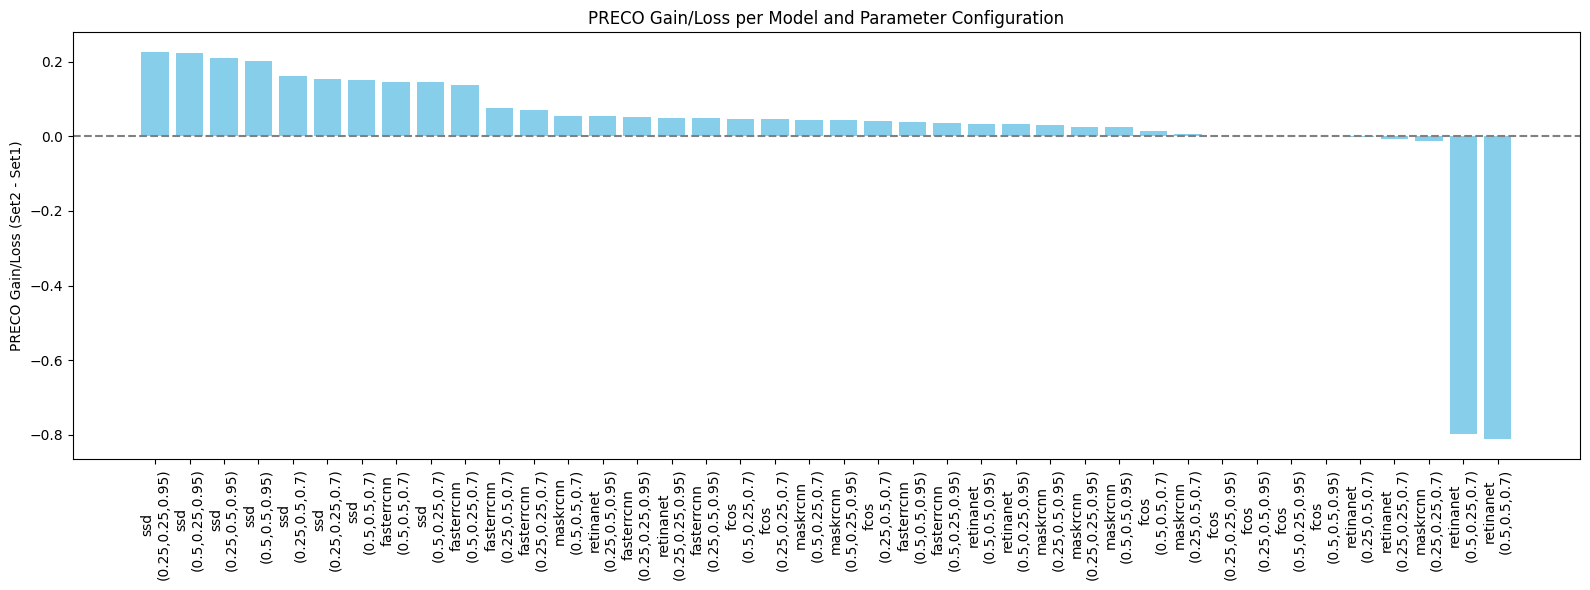

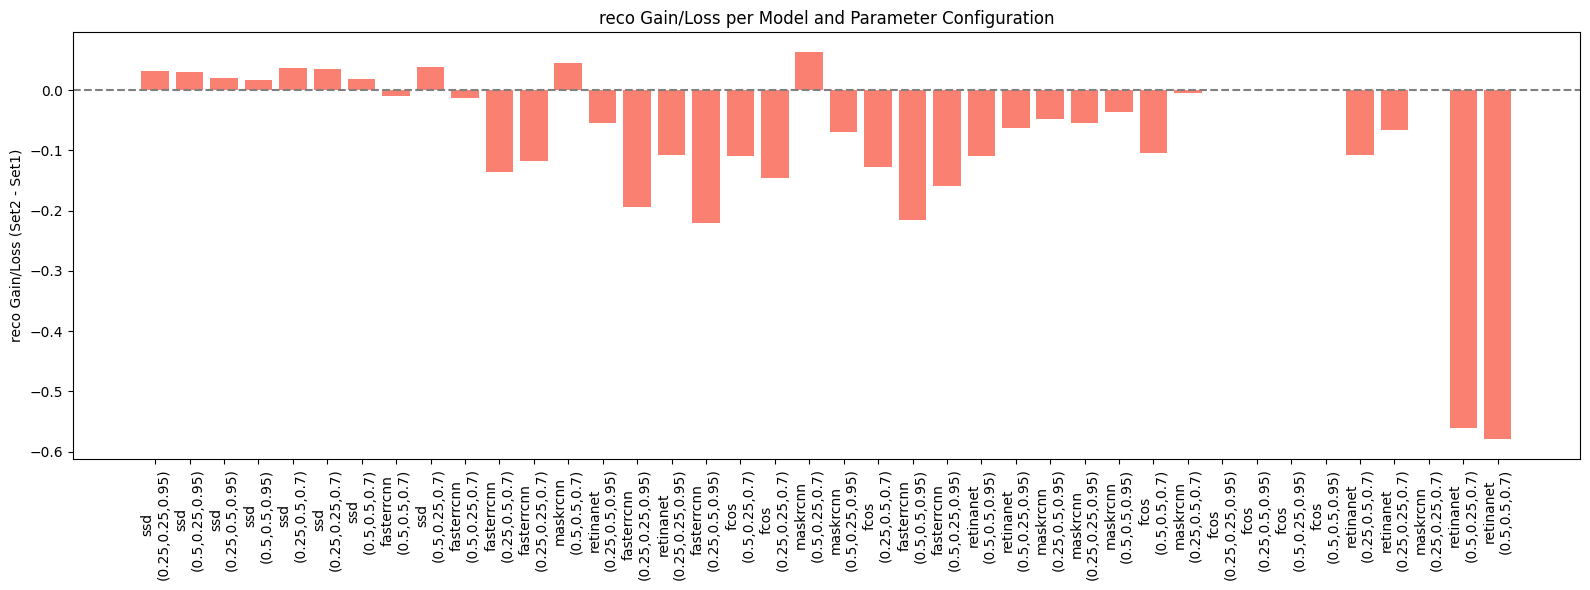

In [13]:
# plot gain/loss between the two datasets

# Load datasets
df1 = pd.read_csv("outExpDLFRCNNDenoised.txt")
df2 = pd.read_csv("outExpDLFRCNNWithNoise.txt")

# Define keys to merge on (parameter combinations)
merge_keys = ['modelType', 'score', 'nms', 'predconf']

# Merge the two datasets on parameter combinations
merged = pd.merge(df1, df2, on=merge_keys, suffixes=('_set1', '_set2'))

# Compute gain/loss
merged['PRECO_diff'] = merged['PRECO_set2'] - merged['PRECO_set1']
merged['reco_diff'] = merged['reco_set2'] - merged['reco_set1']

# Create a readable label for each configuration
merged['label'] = merged['modelType'] + '\n(' + \
                  merged['score'].astype(str) + ',' + \
                  merged['nms'].astype(str) + ',' + \
                  merged['predconf'].astype(str) + ')'

# Sort for better plotting (optional)
merged = merged.sort_values(by='PRECO_diff', ascending=False)

# Plot PRECO gain/loss
plt.figure(figsize=(16, 6))
plt.bar(merged['label'], merged['PRECO_diff'], color='skyblue')
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(rotation=90)
plt.ylabel("PRECO Gain/Loss (Set2 - Set1)")
plt.title("PRECO Gain/Loss per Model and Parameter Configuration")
plt.tight_layout()
plt.savefig("preco_gain_loss.png", dpi=300)
plt.show()

# Plot reco gain/loss
plt.figure(figsize=(16, 6))
plt.bar(merged['label'], merged['reco_diff'], color='salmon')
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(rotation=90)
plt.ylabel("reco Gain/Loss (Set2 - Set1)")
plt.title("reco Gain/Loss per Model and Parameter Configuration")
plt.tight_layout()
plt.savefig("reco_gain_loss.png", dpi=300)
plt.show()




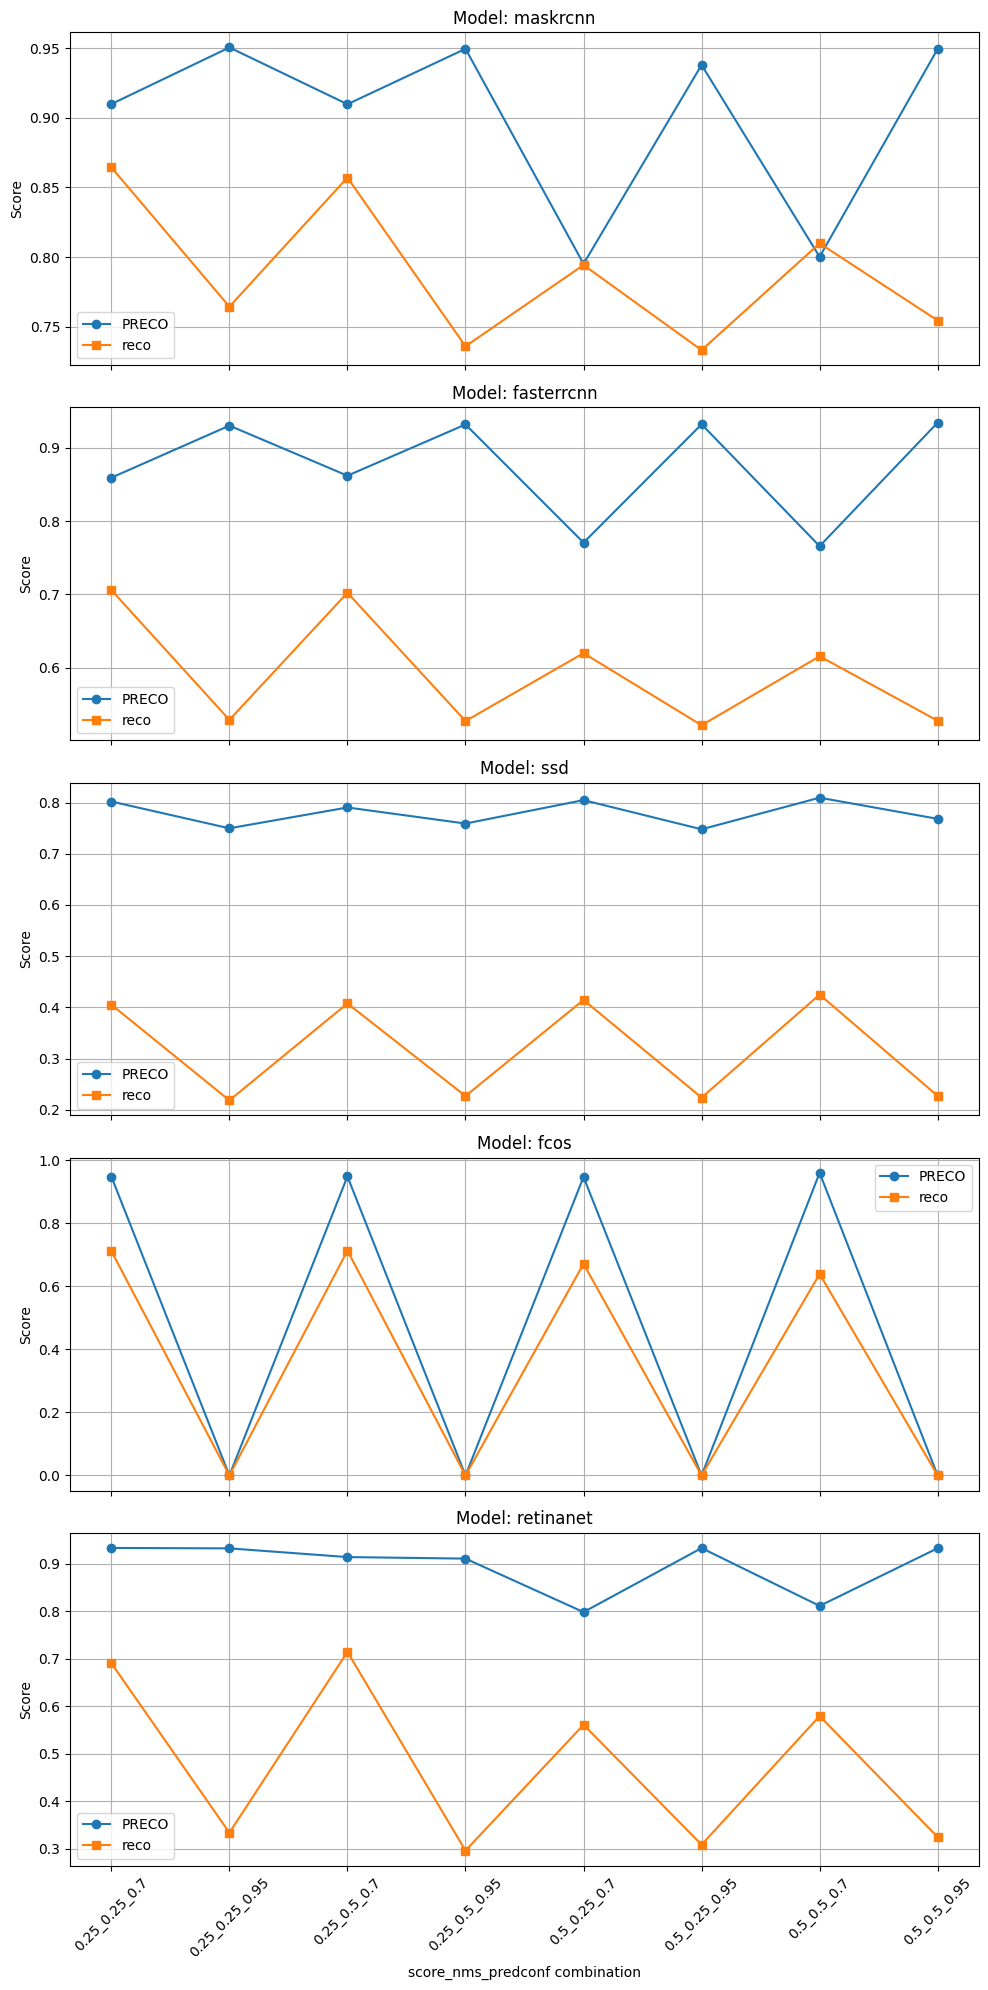

<Figure size 640x480 with 0 Axes>

In [11]:
# Get unique model types
model_types = df['modelType'].unique()

# Create subplots (one row per modelType)
n_models = len(model_types)
fig, axes = plt.subplots(n_models, 1, figsize=(10, 4 * n_models), sharex=True)

if n_models == 1:
    axes = [axes]  # ensure axes is iterable

# Plot for each model
for ax, model in zip(axes, model_types):
    model_df = df[df['modelType'] == model]
    
    # Build a combined key for the x-axis (optional: based on score/nms/predconf)
    x_labels = model_df[['score', 'nms', 'predconf']].astype(str).agg('_'.join, axis=1)
    
    ax.plot(x_labels, model_df['PRECO'], label='PRECO', marker='o')
    ax.plot(x_labels, model_df['reco'], label='reco', marker='s')
    
    ax.set_title(f'Model: {model}')
    ax.set_ylabel('Score')
    ax.legend()
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)

axes[-1].set_xlabel('score_nms_predconf combination')

plt.tight_layout()
plt.show()
plt.savefig("modelsParams.png", dpi=300, bbox_inches='tight')


In [3]:
!ls

best_wts_ResNet50_epo5.pth
classDict.txt
configDLEXP.ini
configDLEXPLAPTOP.ini
config.ini
configLaptop.ini
configLaptopMakeMasks.ini
config.py
configWstation.ini
data
dataHandlding.py
datasets.py
debug
engine.py
exp
experiments.py
expmodelTypefcosscore0.05nms0.25predconf0.7fasterrcnn_resnet50_fpn.pth
expmodelTypefcosscore0.05nms0.25predconf0.9fasterrcnn_resnet50_fpn.pth
expmodelTypemaskrcnnscore0.05nms0.25predconf0.7fasterrcnn_resnet50_fpn.pth
expmodelTypemaskrcnnscore0.05nms0.25predconf0.9fasterrcnn_resnet50_fpn.pth
expmodelTypemaskrcnnscore0.05nms0.5predconf0.7fasterrcnn_resnet50_fpn.pth
expmodelTypemaskrcnnscore0.05nms0predconf0.7fasterrcnn_resnet50_fpn.pth
expmodelTypemaskrcnnscore0.25nms0.25predconf0.7fasterrcnn_resnet50_fpn.pth
expmodelTyperetinanetscore0.05nms0.25predconf0.7fasterrcnn_resnet50_fpn.pth
fasterrcnn_resnet50_fpn.pth
fixKanjiClassifications.ipynb
ideas
imageUtils.py
INRoutExpDLRefinedSUMMARY.txt
kanjiPredictions.txt
kanjiUtils.py
KanjiWIthContext
KanjiWIthContext.zip

In [9]:
# Create a column for the average of PRECO and reco
df['avg_preco_reco'] = df[['PRECO', 'reco']].mean(axis=1)

# Prepare list to hold the rows for the new table
summary_rows = []

for model in df['modelType'].unique():
    model_df = df[df['modelType'] == model]
    
    # Find the row with the best average of (PRECO + reco)/2
    best_row = model_df.loc[model_df['avg_preco_reco'].idxmax()]
    
    summary_rows.append({
        'modelType': model,
        'best_avg': best_row['avg_preco_reco'],
        'Precision_BestAvg': best_row['PRECO'],
        'Recall_BestAvg': best_row['reco'],
        'avg_PREC': model_df['PRECO'].mean(),
        'std_PREC': model_df['PRECO'].std(),
        'avg_Recall': model_df['reco'].mean(),
        'std_Recall': model_df['reco'].std()
    })

# Create the summary DataFrame
summary_df = pd.DataFrame(summary_rows)

# Display the table
from IPython.display import display
display(summary_df.round(4))


,modelType,best_avg,Precision_BestAvg,Recall_BestAvg,avg_PREC,std_PREC,avg_Recall,std_Recall
0,maskrcnn,0.8871,0.9098,0.8644,0.9003,0.0655,0.7892,0.0514
1,fasterrcnn,0.7825,0.8590,0.7060,0.8731,0.0719,0.5939,0.0789
2,ssd,0.6172,0.8094,0.4250,0.7788,0.0256,0.3187,0.1012
3,fcos,0.8304,0.9481,0.7127,0.4752,0.5080,0.3417,0.3661
4,retinanet,0.8145,0.9144,0.7146,0.8960,0.0570,0.4760,0.1792


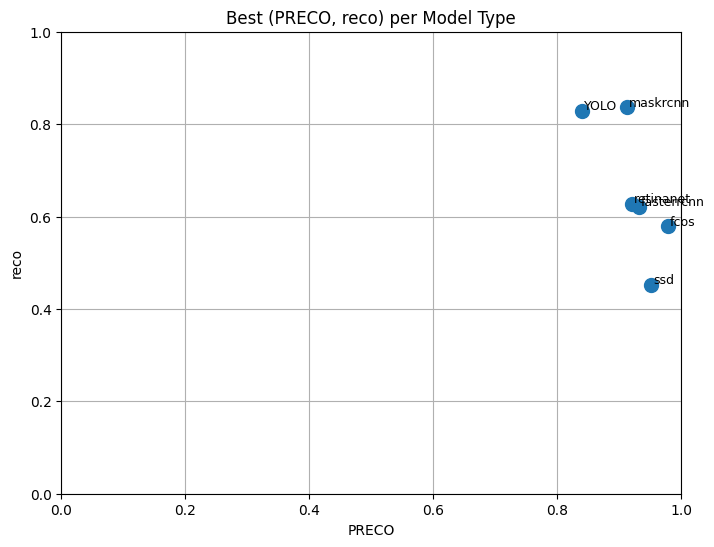

In [11]:
# new functions
import pandas as pd
import matplotlib.pyplot as plt

# === 1) Load your CSV ===
df = pd.read_csv("./noisy.csv")

# === 2) Compute the average of PRECO and reco ===
df['avg'] = df[['PRECO', 'reco']].mean(axis=1)

# === 3) Pick the row with the highest avg per modelType ===
best_per_model = df.loc[df.groupby('modelType')['avg'].idxmax()]

# === 4) Plot ===
plt.figure(figsize=(8, 6))
plt.scatter(best_per_model['PRECO'], best_per_model['reco'], s=100)

# Label each point
for _, row in best_per_model.iterrows():
    plt.text(row['PRECO'] + 0.003, row['reco'] + 0.003, row['modelType'], fontsize=9)

plt.title("Best (PRECO, reco) per Model Type")
plt.xlabel("PRECO")
plt.ylabel("reco")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.show()


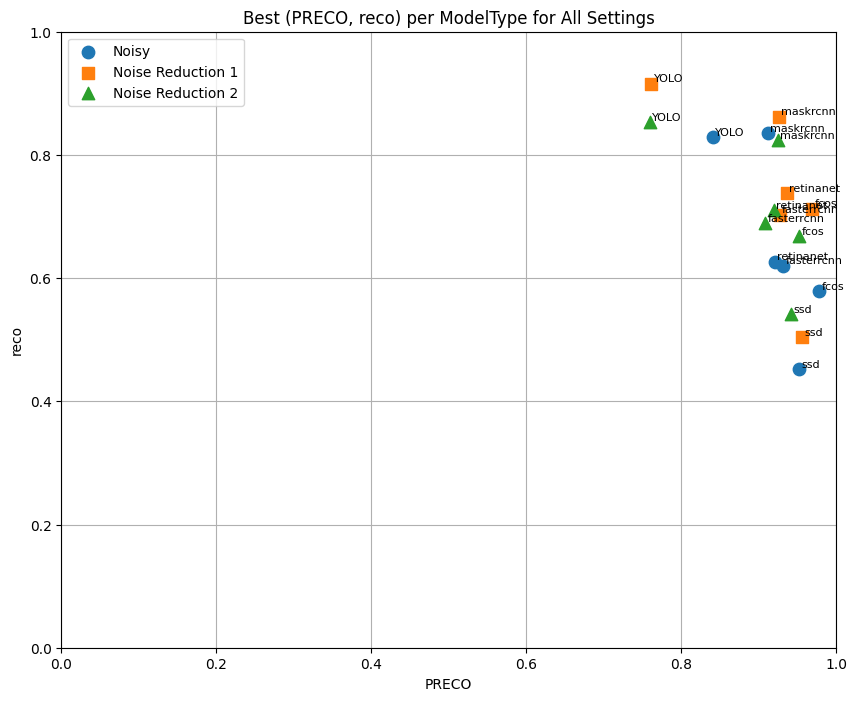

In [23]:
# === 1) Load all three datasets ===
noisy = pd.read_csv("joss2025/noisy.csv")
nr1 = pd.read_csv("joss2025/NR1.csv")
nr2 = pd.read_csv("joss2025/NR2.csv")

# === 2) Compute average ===
for df in [noisy, nr1, nr2]:
    df['avg'] = df[['PRECO', 'reco']].mean(axis=1)

# === 3) Keep best per model ===
best_noisy = noisy.loc[noisy.groupby('modelType')['avg'].idxmax()]
best_nr1 = nr1.loc[nr1.groupby('modelType')['avg'].idxmax()]
best_nr2 = nr2.loc[nr2.groupby('modelType')['avg'].idxmax()]

# === 4) Plot ===
plt.figure(figsize=(10, 8))

plt.scatter(best_noisy['PRECO'], best_noisy['reco'], s=80, marker='o', label='Noisy')
plt.scatter(best_nr1['PRECO'], best_nr1['reco'], s=80, marker='s', label='Noise Reduction 1')
plt.scatter(best_nr2['PRECO'], best_nr2['reco'], s=80, marker='^', label='Noise Reduction 2')

# === 5) Label EVERY point ===
for df in [best_noisy, best_nr1, best_nr2]:
    for _, row in df.iterrows():
        plt.text(row['PRECO'] + 0.003, row['reco'] + 0.003,
                 row['modelType'],
                 fontsize=8)

# === 6) Dynamic axes ===
all_best = pd.concat([best_noisy, best_nr1, best_nr2])
x_min, x_max = all_best['PRECO'].min(), all_best['PRECO'].max()
y_min, y_max = all_best['reco'].min(), all_best['reco'].max()
x_margin = (x_max - x_min) * 0.05
y_margin = (y_max - y_min) * 0.05
#plt.xlim(x_min - x_margin, x_max + x_margin)
#plt.ylim(y_min - y_margin, y_max + y_margin)
plt.xlim(x_min - x_margin, 1)
plt.ylim(y_min - y_margin, 1)
#plt.xlim(0, 1)
#plt.ylim(0, 1)

# === 7) Final touches ===
plt.title("Best (PRECO, reco) per ModelType for All Settings")
plt.xlabel("PRECO")
plt.ylabel("reco")
plt.grid(True)
plt.legend()
plt.savefig("scatterClose.png", dpi=300)

plt.show()






